In [33]:
import datetime as dt
import pandas as pd

In [34]:
observation_date = dt.datetime(year=2021, month=2, day=27)

# We need data from both the observation date and the previous day due to bleed over in the orderflow streaming pipeline
FILE_NAMES = [
"data/btc-usd-coinbase-trades-{td:%Y}-{td:%m}-{td:%d}-consolidated.csv".format(td=observation_date - dt.timedelta(days=1))
,"data/btc-usd-coinbase-trades-{td:%Y}-{td:%m}-{td:%d}-consolidated.csv".format(td=observation_date)]

In [35]:
df = None
for file in FILE_NAMES:
    data = pd.read_csv(file)
    if df is None:
        df = data
    else:
        df = df.append(data)

In [36]:
df = df[df['timestamp'] >= dt.datetime(year=2021,month=2,day=27, tzinfo=dt.timezone.utc).timestamp()]
df = df[df['timestamp'] < dt.datetime(year=2021,month=2,day=28, tzinfo=dt.timezone.utc).timestamp()]
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
df = df.sort_values(by=['externalTradeId']).set_index('datetime')

In [37]:
## Calculate Open, High, Low, Close
resampler = df.resample('1t', closed='left')

In [38]:
ohlc = pd.DataFrame(list(
    map(
        lambda x: {'open': (g:=resampler.get_group(x).sort_values(by='externalTradeId')['price']).iloc[0]
                   , 'high': g.max()
                   , 'low': g.min()
                   , 'close': g.iloc[-1]
                   , 'datetime': x
                  }
        , resampler.groups
    )
)).set_index('datetime')

In [39]:
import matplotlib.pyplot as plit
import mplfinance as mpf

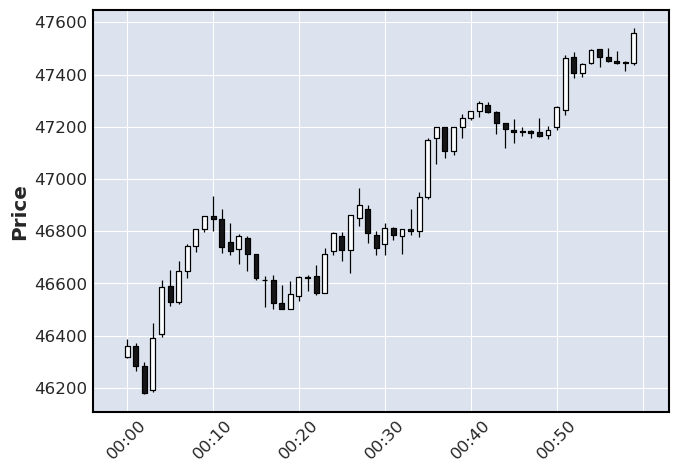

In [40]:
mpf.plot(ohlc[:60], type='candle')

In [41]:
ohlc['timestamp'] = (f := lambda series: [int(pydt.timestamp()) for pydt in series])(ohlc.index.to_pydatetime())
ohlc = ohlc.set_index('timestamp')

In [28]:
out = ohlc.reset_index().to_records(index=False).tobytes()

In [30]:
with open("data/{td:%y}-{td:%m}-{td:%d}-ohlc".format(td=observation_date), 'wb') as out_file:
    out_file.write(out)